# Particle Swarm Pattern Formation Tutorial (ALIFE 2023)

by Alexander Mordvinsev

https://selforgml.github.io/

[DEMO](https://znah.net/icra23)

Learning a pairwise interaction protocol for self-organizing pattern formation.

In [2]:
!pip install -q dm-haiku

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.3/360.3 kB 5.1 MB/s eta 0:00:00


In [4]:
#@title imports and utils
import io
import subprocess
from typing import NamedTuple, Any
from functools import partial
from collections import namedtuple

import numpy as np
import matplotlib.pylab as pl
import PIL.Image, PIL.ImageDraw, PIL.ImageFont
from IPython.display import display, clear_output, Image, Video, HTML
import ipywidgets


import jax
from jax import nn
import jax.numpy as jp
from jax import jit

import optax
import haiku as hk


def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def imshow(a, fmt='jpeg', id=None):
  return display(Image(data=imencode(a, fmt)), display_id=id)

class VideoWriter:
  def __init__(self, filename='_autoplay.mp4', fps=30.0):
    self.ffmpeg = None
    self.filename = filename
    self.fps = fps
    self.view = ipywidgets.Output()
    display(self.view)
    self.frame_count = 0

  def add(self, img):
    img = np.asarray(img)
    h, w = img.shape[:2]
    if self.ffmpeg is None:
      self.ffmpeg = self._open(w, h)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.ffmpeg.stdin.write(img.tobytes())
    #self.view.update(Markdown(f'{w}x{h} frame {self.frame_count}'))
    if self.view and self.frame_count%10==0:
        with self.view:
            clear_output(True)
            imshow(img)
    self.frame_count += 1

  def __call__(self, img):
    return self.add(img)

  def _open(self, w, h):
    cmd = f'''ffmpeg -y -f rawvideo -vcodec rawvideo -s {w}x{h}
      -pix_fmt rgb24 -r {self.fps} -i - -pix_fmt yuv420p {self.filename}'''.split()
    return subprocess.Popen(cmd, stdin=subprocess.PIPE, stderr=subprocess.PIPE)

  def close(self):
    if self.ffmpeg:
        self.ffmpeg.stdin.close()
        self.ffmpeg.wait()
        self.ffmpeg = None

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()
    if self.filename == '_autoplay.mp4':
      self.show()

  def show(self):
      self.close()
      if self.view:
          clear_output(True)
          display(Video(self.filename, embed=True))

def tile2d(a, w=None):
  a = np.asarray(a)
  if w is None:
    w = int(np.ceil(np.sqrt(len(a))))
  th, tw = a.shape[1:3]
  pad = (w-len(a))%w
  a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
  h = len(a)//w
  a = a.reshape([h, w]+list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
  return a

def tree_shapes(tree):
    return jax.tree_map(lambda a:a.shape, tree)

def tree_i(tree, i):
    return jax.tree_map(lambda a:a[i], tree)

def tree_set_i(tree, i, upd):
    def f(a, b):
        a[i] = b
    jax.tree_map(f, tree, upd)

def l2_norm(x, axis=-1, keepdims=False, eps=1e-20):
    return jp.sqrt(jp.square(x).sum(axis, keepdims=keepdims)+eps)

def l2_normlaize(x, axis=-1):
    return x / l2_norm(x, axis, True)

def clip_l2norm(v, max_norm=1.0, axis=-1):
    return v * jp.minimum(1.0, max_norm/l2_norm(v, keepdims=True, axis=axis))

def sample_ball(key, n, R, dim_n=2):
    k1, k2 = jax.random.split(key)
    pos = l2_normlaize(jax.random.normal(k1, [n, dim_n]))
    r = jax.random.uniform(k2, [n, 1])**(1/dim_n)*R
    return pos*r

font_path = pl.matplotlib.get_data_path()+'/fonts/ttf/'

def gen_points(s, font_size=40, normalize_size=False):
    font = PIL.ImageFont.truetype(font_path+'DejaVuSans.ttf', font_size)
    (left, top, right, bottom) = font.getbbox(s)
    w, h = right-left, bottom-top
    im = PIL.Image.new('L', (w, h))
    draw  = PIL.ImageDraw.Draw(im)
    draw.text((-left, -top), s, fill=255, font=font)
    im = np.uint8(im)
    y, x = np.float32(im.nonzero())
    pos = np.column_stack([x, y])
    if len(pos) > 0:
        pos -= (w/2, h/2)
        pos[:,1] *= -1
    if normalize_size:
        pos /= font_size
    return pos

!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-5c566f44-15ae-b89b-5f0c-bdeb48a48a66)


In [6]:
#@title particle rendering utils
def glyph(p):
    return (1.0-(p*p).sum(-1)).clip(0.0)

@partial(jax.jit, static_argnames=['view_size', 'R', 'extent'])
def render(pos, color=jp.ones(3), extent=16.0, view_size=(512, 512), R=0.4):
    w, h = view_size
    pos = pos*w/extent + jp.float32([w, h])/2
    r_px = R*w/extent
    p = pos.T[..., None, None]
    xy = jp.mgrid[-r_px:r_px, -r_px:r_px]
    xy = jp.round(p) + xy[:, None]
    v = glyph((xy-p).transpose([1, 2, 3, 0])/r_px)[...,None]
    x, y = jp.int32(xy)
    inside = (x >= 0) & (y >= 0) & (x < w) & (y < h)
    v = v*color[...,None,None,:]
    return 1.0-jp.zeros([h, w, color.shape[-1]]).at[y, x].add(v*inside[...,None], mode='drop')[::-1]

(113, 2)


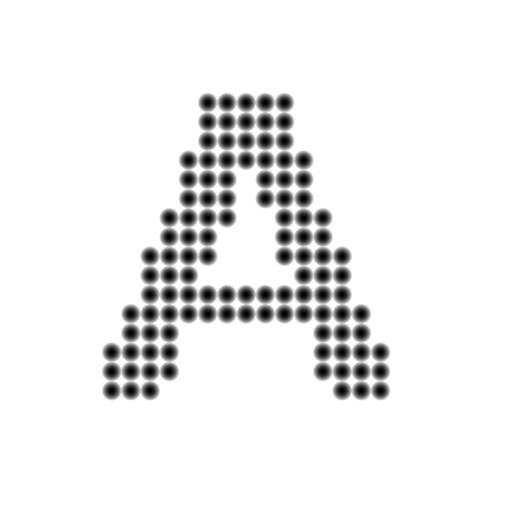

In [7]:
#@title TARGET SHAPE {vertical-output:true}
target = jp.asarray(gen_points('A', font_size=22))*0.75
print(target.shape)
imshow(render(target, extent=20.0))

## Translation-Rotation-Reflection-Permutation invariant shape matching loss

Basic idea:
* Convert Nx2 matrix of point positions into NxN matrix of pairwise distances `M`
* Sort rows of `M` independently. Now each point is represented by a sorted N-dimensional vector of distances to all other points
* Use [Sliced Optimal Transport](https://colab.research.google.com/github/znah/notebooks/blob/master/sliced_optimal_transport.ipynb) to match current and target N-dimensional vector distributions

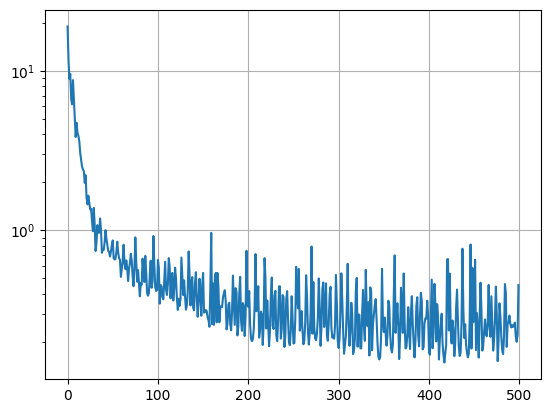

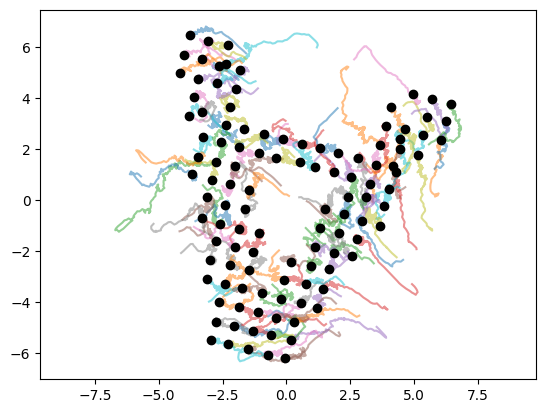

In [8]:
#@title {vertical-output:true}
class PairwiseOTLoss:
    def __init__(self, target_points, scale_inv=False):
        self.scale_inv = scale_inv
        self.M0 = self.calcM(target_points)

    def calcM(self, points, eps=1e-10):
        d2 = jp.square(points[:,None,:]-points).sum(-1).sort(1)
        d = jp.sqrt(d2+eps)
        if self.scale_inv:
            d = d/(d.mean()+eps)
        return d

    def __call__(self, points, key, proj_n=64):
        M, M0 = self.calcM(points), self.M0
        # perform sliced OT matching in n-dim space
        proj = jax.random.normal(key, [M.shape[0], proj_n])
        proj /= (proj*proj).sum(0)**0.5
        return jp.square((M@proj).sort(0)-(M0@proj).sort(0)).sum()/proj.shape[-1]

target_loss_f = PairwiseOTLoss(target)
@jit
def step_f(p, key):
    return jax.value_and_grad(target_loss_f)(p, key)

key = jax.random.PRNGKey(42)
p = sample_ball(key, len(target), 6.0, dim_n=target.shape[-1])
opt = optax.adam(0.1, 0.5, 0.5)
state = opt.init(p)
log, tracks = [], []
for i in range(500):
    key, k1 = jax.random.split(key)
    loss, g = step_f(p, k1)
    log.append(loss)
    dp, state = opt.update(g, state, p)
    p += dp
    tracks.append(p)
pl.plot(log)
pl.grid()
pl.yscale('log');
pl.show()
p = np.array(tracks)
pl.plot(p[...,0], p[...,1], alpha=0.5);
pl.plot(p[-1,:,0], p[-1,:,1], 'ok');
pl.axis('equal');
pl.show()

This loss is minimized when two shapes match up-to a transformation. Its gradient is noisy and may have spurious local minima, but it's good enough for Adam to find a way. Let's see if we can herd particles this way.

## Particle system dynamics

* Each particle has a position and a state: $p_i \in \mathbb{R}^2,\; s_i \in \mathbb{R}^3$.

* Initially all particles are randomly scattered on a plane and have the same state $s_i^0 = s^0$.

* Particles communicate their state with messages and receive messages from other particles. Message reception triggers the receiver position and state change. The receiver knows its own state, sender state, and the distance to the sender. The receiver uses a learned function to compute the change of its own state and the desired move towards or away from the sender.

$$\mathbf{r}_{ij}=p_i - p_j$$

$$ \text{msg}_{i \leftarrow j} = (\Delta s_{i \leftarrow j}, \Delta r_{i \leftarrow j}) = f_\theta(s_i, s_j, \|\mathbf{r}_{ij}\|) $$

* During training we assume that the actual update happens after all pairs of particles exchanged messages, and averages contributions of all messages. State vectors iare also nomalized after each update.

$$ s^{\,t+1}_i = \text{normalize}\Big( s^{\,t}_i + \frac{1}{n}\sum_j \Delta s_{i \leftarrow j} \Big)$$

$$ p^{\,t+1}_i = p^{\,t}_i + \frac{1}{n}\sum_j \Delta r_{i \leftarrow j}\frac{\mathbf{r}_{ij}}{\|\mathbf{r}_{ij}\|}$$


<!--$$ s^{\,t+1}_i = \text{normalize} \Big( s^{\,t}_i + \frac{1}{n}\sum_j f_\theta(s_i, s_j, \|\mathbf{r}_{ij}\|) \Big)$$

$$ p^{\,t+1}_i = p^{\,t}_i + \frac{1}{n}\sum_j g_\theta(s_i, s_j, \|\mathbf{r}_{ij}\|)\frac{\mathbf{r}_{ij}}{\|\mathbf{r}_{ij}\|}$$-->

Here is an example of a randomly initialized interaction rule behavior:

In [9]:
#@title {vertical-output: true}
target_point_n, dim_n = target.shape
emb_n = 3

State = namedtuple('State', 'pos emb')

def init_state(key, n=len(target), R=6.0, dim_n=dim_n):
    pos = sample_ball(key, n, R, dim_n=dim_n)
    emb = jp.ones([n, emb_n])
    return State(pos, emb)

@hk.without_apply_rng
@hk.transform
def step_f(st: State):
    dp = st.pos[:,None,:]-st.pos
    r = (dp*dp).sum(-1, keepdims=True).clip(1e-5)**0.5
    # combine sender and receiver states and the distance information
    msg = st.emb[:,None,:] - st.emb + r
    # compute per-message actions
    x = hk.Linear(80)(msg)
    x = jp.sin(x)
    y = hk.Linear(emb_n+1, with_bias=False)(x)
    # apply agregated updates
    pos = st.pos + (dp/r*y[...,-1:]).mean(1)
    emb = st.emb + (y[...,:-1]).mean(1)
    # L1-normalize particle states
    emb = emb/(jp.abs(emb).mean(-1, keepdims=True)+1e-10)
    return State(pos, emb)

def run(params, state0, step_n):
  def f(s, _):
    s = step_f.apply(params, s)
    return s, s
  tracks = jax.lax.scan(f, state0, None, step_n)[1]
  return [State(*v) for v in zip(*tracks)]

key = jax.random.PRNGKey(42)
state0 = init_state(key)
params0 = step_f.init(key, state0)
print(tree_shapes(params0))

tracks = [state0]+run(params0, state0, 200)

def render_video(tracks):
  with VideoWriter() as vid:
    for pos, emb in tracks:
      vid(render(pos, emb[:,:3]*0.3+0.5, 25))

render_video(tracks)

In [12]:
#@title Setup training

# quantize weights for web demo export
Q = 100.0
def quantize(params):
  return jax.tree_map(
      lambda p:p + jax.lax.stop_gradient(jp.round(p*Q)/Q - p), params)

def loss_f(params, state0, key, unroll_n=8):
    q_params = quantize(params)
    def f(state0):
        state = jax.lax.fori_loop(0, unroll_n,
            lambda i,s: step_f.apply(q_params, s), state0)
        pos0, pos = state0.pos, state.pos
        loss = target_loss_f(pos, key)
        # drift and motion regularization
        center0, center = pos0.mean(0), pos.mean(0)
        drift = jp.square(center-center0).mean() * 0.1
        move = l2_norm(pos0-pos).mean() * 0.2
        return loss+drift+move, state
    losses, end_states = jax.vmap(f)(state0)
    return losses.mean(), end_states

lr = optax.piecewise_constant_schedule(1e-2, {1000:0.3, 3000:0.3})
opt = optax.adamw(lr, 0.9, 0.99)

Train = namedtuple('Train', 'key params opt_state')

@jax.jit
def opt_step_f(tr: Train, state0):
    key, k1 = jax.random.split(tr.key)
    grad_f = jax.value_and_grad(loss_f, has_aux=True)
    (loss, end_state), grad = grad_f(tr.params, state0, k1)
    dparams, opt_state = opt.update(grad, tr.opt_state, tr.params)
    params = optax.apply_updates(tr.params, dparams)
    return Train(key, params, opt_state), dict(loss=loss, end_state=end_state)

train = Train(key, params0, opt.init(params0))
# state cache
pool = jax.vmap(init_state)(jax.random.split(key, 256))
pool = jax.tree_map(np.array, pool)
batch_size = 16
log = []

In [ ]:
#@title Training loop {vertical-output:true}
vis = ipywidgets.Output()
status = ipywidgets.Output()
display(status)
display(vis)
for i in range(4000):
    k1, k2 = jax.random.split(train.key)
    batch_i = np.asarray(jax.random.choice(k1, len(pool.pos), [batch_size], False))
    batch = tree_i(pool, batch_i)
    tree_set_i(batch, 0, init_state(k2))
    train, aux = opt_step_f(train, batch)
    tree_set_i(pool, batch_i, aux['end_state'])
    log.append(aux['loss'])
    if i%200==0:
        vis.clear_output(True)
        with vis:
          img = jax.vmap(partial(render, view_size=(160,160)))(batch.pos, batch.emb*0.3+0.5)
          imshow(tile2d(img[:8], 4))

          pl.plot(log[:], '.', alpha=0.1)
          pl.yscale('log')
          pl.grid()
          pl.show()
    if i%50 == 0:
      status.clear_output(True)
      with status:
        print(len(log), aux['loss'])


Output()

Output()

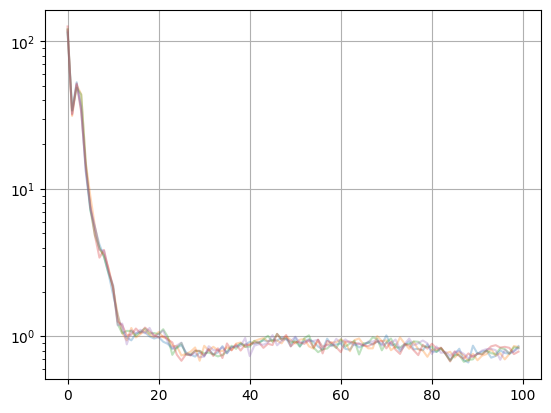

In [16]:
#@title Evaluate loss across time steps {vertical-output:true}
key0 = jax.random.PRNGKey(12)

def f(s, key):
  s = step_f.apply(train.params, s)
  ks = jax.random.split(key, 5)
  loss = jax.vmap(partial(target_loss_f, s.pos, proj_n=256))(ks)
  return s, loss
keys = jax.random.split(key0, 100)
s0 = init_state(key, n=len(target))
_, loss_log = jax.lax.scan(f, s0, keys)

pl.plot(loss_log, alpha=0.3)
pl.grid()
pl.yscale('log');

In [22]:
#@title Pattern damage recovery {vertical-output:true}
tracks = [state0]
tracks += run(train.params, tracks[-1], 100)
last = tracks[-1]
mask = last.pos[:,0]<last.pos[:,0].mean()
tracks += [tree_i(last, mask)]*20
tracks += run(train.params, tracks[-1], 100)
render_video(tracks)

In [20]:
#@title Web demo weights export
p1, p2 = train.params['linear'], train.params['linear_1']
p = jp.vstack([p1['w'], p1['b'], p2['w'].T]).T.ravel()
p = np.int32(jp.round(p*Q))
param_str = '[%s]'%','.join(map(str, p))
param_str

'[44,-7,-83,10,31,-1,7,18,-31,29,-8,20,-5,9,-2,4,60,-89,-73,-106,-13,-10,17,-93,-12,42,114,10,34,22,93,-4,9,-18,51,-7,22,-28,13,12,-45,-40,8,-30,23,-34,9,4,113,-88,-27,-19,58,-79,-39,20,-37,48,30,-19,-15,-9,-32,2,24,92,-58,-13,0,-25,-7,-1,29,55,-7,13,-23,38,31,-5,-3,39,-18,-11,25,7,-2,-12,-45,52,-45,15,15,-5,-33,-22,86,57,-85,-15,6,-64,-35,-7,-20,15,-118,-35,-26,8,8,-34,-36,127,14,-11,-50,-84,-18,26,48,43,16,17,17,-19,-15,17,5,-8,4,-3,0,3,3,-1,-9,64,-4,5,-5,-3,-22,11,-7,66,0,21,-11,11,1,9,87,77,1,72,4,17,6,119,-117,3,-86,5,-87,-74,-64,-5,-76,57,61,3,-28,26,-86,0,-63,41,-19,-2,-1,-35,-5,-25,56,-25,11,4,-3,7,24,21,59,5,36,22,46,-21,-12,21,-38,23,-29,-1,-3,5,-19,-18,-84,-94,-43,-83,-70,-22,-143,-104,-41,-1,-4,-7,-2,15,-29,-15,-24,8,-2,12,-32,-1,3,13,15,-12,39,2,21,-16,39,18,-16,-72,-126,-63,-37,-15,-21,-67,52,56,35,6,5,83,41,-10,4,-69,11,-10,7,5,10,-8,79,91,14,10,165,81,16,22,-32,91,-8,-4,6,24,-65,6,-41,-51,11,13,26,-53,-40,22,-1,-79,2,-19,13,-25,-32,-4,-4,-12,36,-3,26,-23,6,-15,44,-17,18

In [19]:
#@title [SwissGL](http://swiss.gl) demo
HTML('''
<script src="https://selforgml.github.io/swissgl.js"></script>
<button onclick="reset()">reset</button></br>
<canvas width="600" height="600"></canvas>
<script>
"use strict";
const canvas = document.querySelector('canvas');
const glsl = SwissGL(canvas);

let points
function reset() {
  points = glsl({seed:Math.random()*12345, FP:`
    vec3 rnd = hash(ivec3(I.xy, seed));
    FOut = vec4((rnd.xy-0.5)*8.0, 0.0, 1.0);
    FOut1 = vec4(1.0);
    `}, {story:2, size:[20,20], format:'rgba32f', layern:2, tag:'points'})
}
reset();

const W = new Float32Array(%s.map(v=>v/100.0));

function frame() {
  requestAnimationFrame(frame);
  glsl({W, dt:0.1, FP:`uniform vec4 W[${W.length/4}];
  void fragment() {
    FOut = Src(I,0); FOut1 = Src(I,1);
    vec3 pos = FOut.xyz, dpos=vec3(0);
    vec3 state = FOut1.xyz, dstate=vec3(0);
    float count = 0.0;
    for (int y=0; y<ViewSize.y; ++y)
    for (int x=0; x<ViewSize.x; ++x) {
        vec4 pos1 = Src(ivec2(x,y),0);
        if (pos1.w==0.0) continue;
        count += 1.0;
        vec3 dp = (pos-pos1.xyz);
        float r = length(dp)+1e-5;
        vec4 msg = vec4(state - Src(ivec2(x,y),1).xyz + r, 1.0), upd=vec4(0);
        for (int i=0; i<W.length(); i+=2) {upd += sin(dot(msg, W[i]))*W[i+1];}
        dstate += upd.xyz;
        dpos += dp/r*upd.w;
    }
    count = max(count, 1.0);
    pos   += dt*dpos/count;
    state += dt*dstate/count;
    vec3 a = abs(state);
    state *= 3.0/(a.x+a.y+a.z);
    FOut.xyz = pos;
    FOut1 = vec4(state,0);
  }`}, points);

  glsl({points:points[0], Grid:points[0].size,
    Blend:'d*(1-sa)+s*sa', Inc:'varying vec3 color;',VP:`
    VPos.xy = points(ID.xy,0).xy / 8.0 + XY*0.015;
    color = points(ID.xy,1).xyz*0.3+0.5;`,
    FP: `color, smoothstep(1.0, 0.6, length(XY))*0.9`})
}
frame();

</script>
'''%param_str)